# Opening a new Vietnamese restaurant in New York City

## This project is for Capstone Course - Data Science Specialization IBM on Coursera - 1st Feb 2019

### Import libraries

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  53.42 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  36.68 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  41.46 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  49.36 MB/s


### Download & explore dataset

In [4]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


### Use geopy library to get the latitude and longitude values of New York City

In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


### Create a map of New York with neighborhoods superimposed on top

In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Define Foursquare Credentials and Version

In [31]:
CLIENT_ID = 'JDFX0AATYSVAUILXH04ABUR12BJDCGKERPSSHUAGZLTN25JS'
CLIENT_SECRET = 'UYJQP4DEAY0HLWH0BSGZSHHJJ5VZHYBGJHAFGU2P0WUZTNUC' 
VERSION = '20190201' 

### Get top 100 venues in each neighborhood (radius = 500m), count the nr of restaurants & the nr of Vietnamese restaurants in that area

In [32]:
def getNrOfRestaurants(names, latitudes, longitudes, radius=500, limit = 100):
    
    venues_count=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        restaurants_count = 0
        VNrestaurants_count = 0
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # count nr of restaurant
        for v in results:
            if 'Restaurant' in v['venue']['categories'][0]['name']:
                restaurants_count = restaurants_count + 1
            if 'Vietnamese Restaurant' in v['venue']['categories'][0]['name']:
                VNrestaurants_count = VNrestaurants_count + 1
        
        # return only relevant information for each neighborhood
        venues_count.append([(
            name, 
            lat, 
            lng, 
            restaurants_count,
            VNrestaurants_count)])
            
    nearby_venues = pd.DataFrame([item for venue_count in venues_count for item in venue_count])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Nr of restaurants', 
                  'Nr of Vietnamese restaurants']
    
    return(nearby_venues)

newyork_venues = getNrOfRestaurants(neighborhoods['Neighborhood'], neighborhoods['Latitude'], neighborhoods['Longitude'])
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Nr of restaurants,Nr of Vietnamese restaurants
0,Wakefield,40.894705,-73.847201,0,0
1,Co-op City,40.874294,-73.829939,1,0
2,Eastchester,40.887556,-73.827806,6,0
3,Fieldston,40.895437,-73.905643,0,0
4,Riverdale,40.890834,-73.912585,0,0


In [36]:
newyork_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Nr of restaurants,Nr of Vietnamese restaurants
0,Wakefield,40.894705,-73.847201,0,0
1,Co-op City,40.874294,-73.829939,1,0
2,Eastchester,40.887556,-73.827806,6,0
3,Fieldston,40.895437,-73.905643,0,0
4,Riverdale,40.890834,-73.912585,0,0
5,Kingsbridge,40.881687,-73.902818,14,0
6,Marble Hill,40.876551,-73.910660,2,0
7,Woodlawn,40.898273,-73.867315,3,0
8,Norwood,40.877224,-73.879391,6,0
9,Williamsbridge,40.881039,-73.857446,3,0


In [38]:
newyork_venues.describe()

,Neighborhood Latitude,Neighborhood Longitude,Nr of restaurants,Nr of Vietnamese restaurants
count,306.000000,306.000000,306.000000,306.000000
mean,40.701362,-73.946254,8.562092,0.117647
std,0.097498,0.121202,9.908983,0.419854
min,40.505334,-74.246569,0.000000,0.000000
25%,40.617778,-74.000062,2.000000,0.000000
50%,40.702969,-73.932009,4.000000,0.000000
75%,40.766645,-73.857525,11.750000,0.000000
max,40.908543,-73.708847,44.000000,4.000000


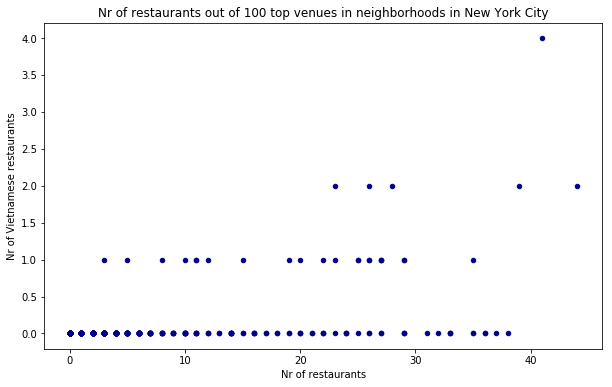

In [40]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

newyork_venues.plot(kind='scatter', x='Nr of restaurants', y='Nr of Vietnamese restaurants', figsize=(10, 6), color='darkblue')

plt.title('Nr of restaurants out of 100 top venues in neighborhoods in New York City')
plt.xlabel('Nr of restaurants')
plt.ylabel('Nr of Vietnamese restaurants')

plt.show()

As we can see from the scatter plot, most of neighborhoods in New York city don't have any Vietnamese restaurant in their top 100 venues. It would be a business opportunity for Mr X. who wants to open a new branch here. However we should consider also the competition on the market by excluding all neighborhoods that already have too many famous restaurants (>30) and the ones that have too few restaurants as top venues as the need of eating out seems to be low (<10). In short, I would recommend a list of neighborhoods that have no Vietnamese restaurant and have from 10 to 30 other restaurants in top 100 venues.

### Find out the list of recommended neighborhoods

In [47]:
recommended_neighborhood = []
for index, row in newyork_venues.iterrows():
    if (row['Nr of Vietnamese restaurants'] == 0 and  row['Nr of restaurants'] in range(10, 20)):
        recommended_neighborhood.append(row['Neighborhood'])
print(recommended_neighborhood)

['Kingsbridge', 'Pelham Bay', 'Brighton Beach', 'Gowanus', 'Cypress Hills', 'Bath Beach', 'Boerum Hill', 'Prospect Lefferts Gardens', 'Prospect Park South', 'East Williamsburg', 'Fort Hamilton', 'Inwood', 'Hamilton Heights', 'Manhattanville', 'Central Harlem', 'East Harlem', 'Lincoln Square', 'Soho', 'Battery Park City', 'Howard Beach', 'Long Island City', 'Sunnyside', 'Ridgewood', 'Rego Park', 'College Point', 'Rockaway Beach', 'Queensboro Hill', 'Ravenswood', 'Stapleton', 'Eltingville', 'Ditmas Park', 'Bulls Head', 'Mill Basin', 'Jamaica Hills', 'Fulton Ferry', 'Dumbo', 'Hudson Yards']
